In [1]:
import pyreadr
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
import os
import itertools

np.random.seed(0)

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')


features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

In [3]:
model_RF_C = RandomForestClassifier( 
                            #    max_samples = 10000,   #If bootstrap is True, num of samples to draw from X to train each base estimator.
                                bootstrap = False,      # If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  # min num of samples required to be at a leaf node. 
                                n_estimators = 40,      # num of trees in the forest.
                                max_features = 30       # num of features to consider when looking for the best split:
                                )
fit_RF_C = model_RF_C.fit(training_sample[features], training_sample.R1M_Usd_C)

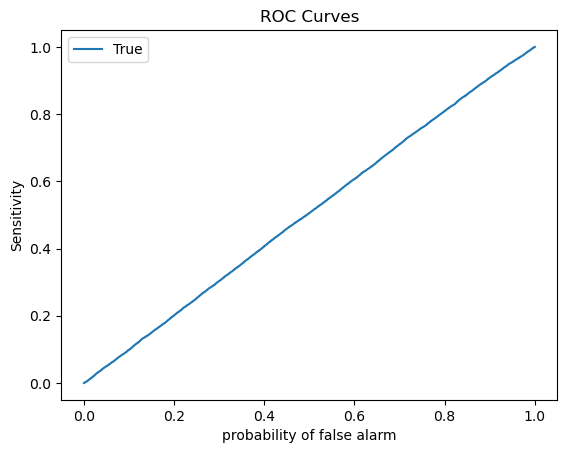

In [4]:
scores = fit_RF_C.predict_proba(testing_sample[features])[:,1]
fpr, tpr, thresholds = roc_curve(testing_sample.R1M_Usd_C, scores)
roc_auc = roc_auc_score(testing_sample.R1M_Usd_C, scores)
plt.plot(fpr, tpr)
plt.title("ROC Curves")
plt.xlabel("probability of false alarm")
plt.ylabel("Sensitivity")
plt.legend([True])

<Axes: >

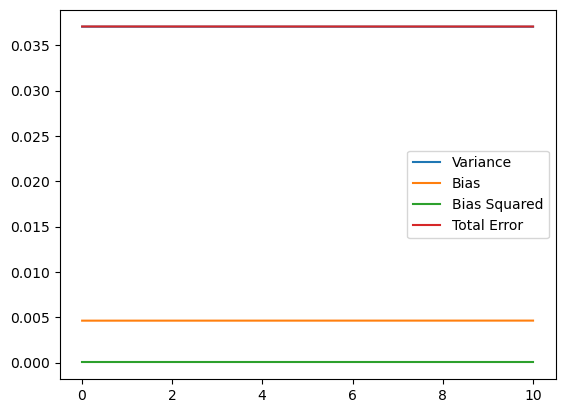

In [5]:
y_penalized = training_sample['R1M_Usd'] 
X_penalized = training_sample[features]
x_penalized_test = testing_sample[features]
y_penalized_test = testing_sample['R1M_Usd']

lambdas = np.logspace(-2,1, num=100)
coefs = {}
models = {}
ridge_bias = {}
ridge_var  = {}
for _lambda in lambdas:
    models[_lambda] = Ridge(alpha=_lambda).fit(X_penalized, y_penalized)
    coefs[_lambda] = models[_lambda].coef_
    ridge_bias[_lambda] = np.mean(models[_lambda].predict(x_penalized_test) - y_penalized_test)
    ridge_var[_lambda] = np.var(models[_lambda].predict(x_penalized_test) - y_penalized_test)
lambda_df = pd.DataFrame({'Variance': ridge_var,'Bias': ridge_bias})
lambda_df['Bias Squared'] = lambda_df['Bias'] ** 2
lambda_df['Total Error'] = lambda_df['Bias Squared'] +  lambda_df['Variance']
lambda_df.plot()



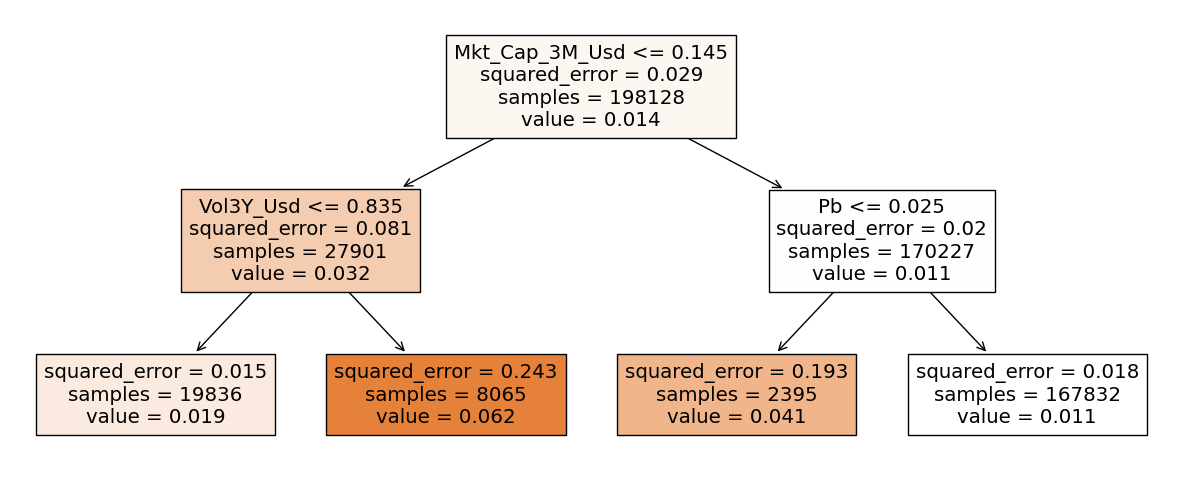

In [6]:
fit_tree_simple = DecisionTreeRegressor(
                                max_depth = 2,              
                                ccp_alpha = 0.00001    #Complexity para used for Min Cost-Complexity Pruning. smaller cp = more leaves    
                                )
fit_tree_simple.fit(training_sample[features], training_sample.R1M_Usd)
fig = plt.figure(figsize=(15,6))
_ = plot_tree(fit_tree_simple, 
                   feature_names=features,  
                   class_names=data_ml.R1M_Usd,
                   filled=True)

In [7]:
print("Bias:", (fit_tree_simple.predict(testing_sample[features]) - testing_sample['R1M_Usd']).mean() )
print("VAR:",  (fit_tree_simple.predict(testing_sample[features]) - testing_sample['R1M_Usd']).var() )

Bias: 0.0049739165383303205
VAR: 0.03698599912955521


In [8]:
top20 = training_sample['R1M_Usd'].quantile(0.8) 
bottom20= training_sample['R1M_Usd'].quantile(0.2)
train_features = training_sample[(training_sample['R1M_Usd'] > top20) | (training_sample['R1M_Usd'] < bottom20) ]
train_features_xgb = train_features[features_short]
train_label_xgb = train_features['R1M_Usd']
xgb_test = testing_sample[features_short]

mono_const = np.zeros(len(features_short))
mono_const += (np.array(features_short)=='Mkt_Cap_12M_Usd' ) * (-1)
mono_const += (np.array(features_short)=='Pb' ) * (-1)
mono_const += (np.array(features_short)=='Mom_11M_Usd' ) * 1

model_xgb = xgb.XGBRegressor(     
              learning_rate  = 0.3,                                                                        
              objective = "reg:squarederror",                                                          
              max_depth = 4,                                                               
              subsample=0.6,             
              colsample_bytree=0.7,      
              reg_lambda = 1,                  #L2 regularization on weights
              gamma = 0.1,                     #Min loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators = 30,               #Num of trees in random forest to fit.
              monotone_constraints = '('+','.join(str(int(x)) for x in mono_const) + ')', 
              rate_drop=0.1,
              verbosity  = 0                                                              
            )
fit_xgb = model_xgb.fit(train_features_xgb,train_label_xgb )    

In [9]:
print("Bias:", (fit_xgb.predict(xgb_test) - testing_sample['R1M_Usd']).mean() )
print("VAR:",  (fit_xgb.predict(xgb_test) - testing_sample['R1M_Usd']).var() )

Bias: 0.003014050355586847
VAR: 0.03836028685273882


In [10]:
xgb_test = testing_sample[features_short]
print("Bias:", (fit_xgb.predict(xgb_test) - testing_sample['R1M_Usd']).mean() )
print("Hit ratio:", (fit_xgb.predict(xgb_test) * testing_sample['R1M_Usd'] > 0 ).mean() )

Bias: 0.003014050355586847
Hit ratio: 0.4996724020054695


In [11]:
eta = [0.1, 0.3, 0.5, 0.7, 0.9]         
nrounds = [10, 50, 100]                 
lambdas =  [0.01, 0.1, 1, 10, 100]
param_grid = list(itertools.product(eta, nrounds, lambdas))



In [12]:
def grid_par(train_features, train_label , test_features, test_label, eta, nrounds, lambda_val):
    model_xgb = xgb.XGBRegressor(     
              learning_rate  = eta,                                                                      
              objective = "reg:squarederror",                                   
              max_depth = 5,                                                               
              reg_lambda = lambda_val,              #L2 regularization on weights
              gamma = 0.1,                          #Min loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators =int(nrounds),          #Num of trees in random forest to fit.
              verbosity  = 0                                                              
            )
    fit_xgb = model_xgb.fit(train_features, train_label)
    return mean_squared_error(fit_xgb.predict(test_features), test_label)
results = list(map(lambda p: grid_par(train_features_xgb,train_label_xgb,
                                      xgb_test, testing_sample['R1M_Usd'], *p), param_grid))
grd_df = pd.DataFrame(param_grid, columns=["eta", "nrounds", "lambda"])
grd_df["error"] = results


# param_grid = {
#     "learning_rate": [0.1, 0.3, 0.5, 0.7, 0.9], 
#     "n_estimators": [10, 50, 100],  
#     "reg_lambda": [0.01, 0.1, 1, 10, 100]  
# }
# model_xgb = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     max_depth=5,  
#     gamma=0.1,  
#     verbosity=0  
# )
# grid_search = GridSearchCV(
#     estimator=model_xgb,  
#     param_grid=param_grid,  
#     scoring="neg_mean_squared_error",  
#     cv=5,  
#     n_jobs=-1  
# )
# grid_search.fit(train_features_xgb, train_label_xgb)
# grd_df = pd.DataFrame(grid_search.cv_results_)
# grd_df = grd_df[['param_learning_rate', 'param_n_estimators', 'param_reg_lambda', 'mean_test_score']]
# print("Best Parameters:", grid_search.best_params_)
# print("Best MSE Score:", -grid_search.best_score_)
    

C:\Users\SE24171\AppData\Local\Temp\ipykernel_22592\2647381250.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_22592\2647381250.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_22592\2647381250.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_22592\2647381250.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), font

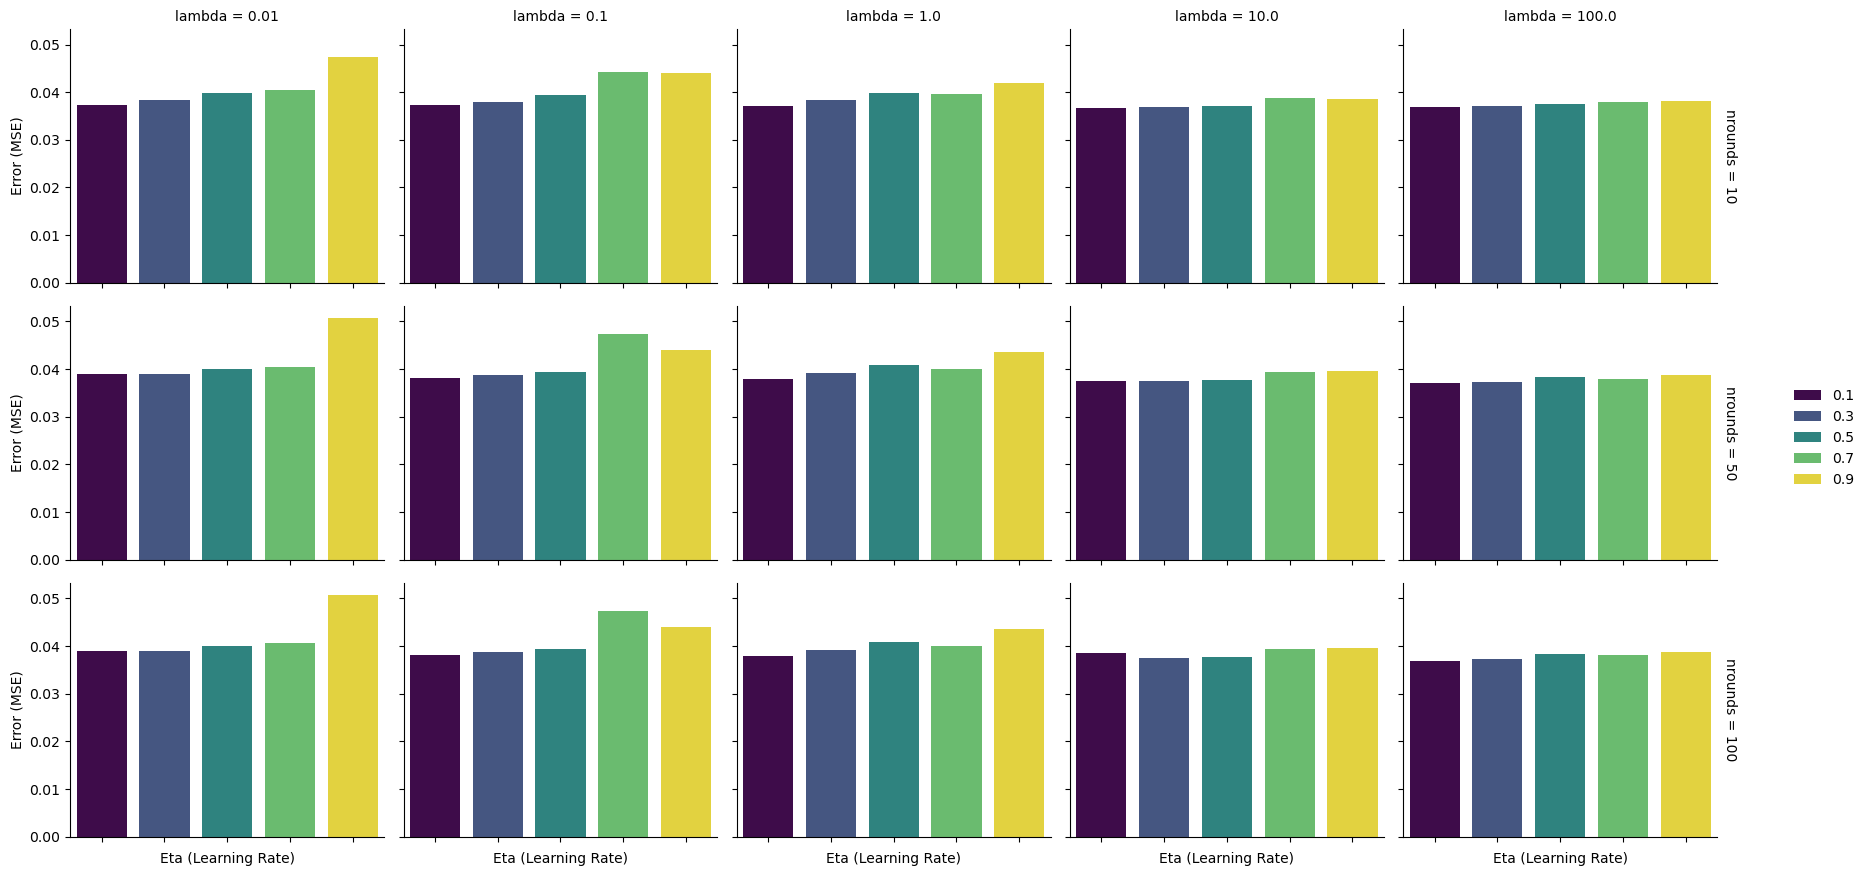

In [13]:
g = sns.FacetGrid(grd_df, row="nrounds", col="lambda", margin_titles=True, height=3, aspect=1.2)
g.map_dataframe(sns.barplot, x="eta", y="error", hue="eta", dodge=False, palette="viridis")
g.set_axis_labels("Eta (Learning Rate)", "Error (MSE)")
g.set_titles(row_template="nrounds = {row_name}", col_template="lambda = {col_name}")
g.add_legend()
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

plt.show()

In [14]:
eta_range = (0.2, 0.8)
lambdas_range = (0.1, 15)
nrounds_range = (10, 100)

def optimize_xgb(train_features, train_label, test_features, test_label):
    def objective(eta, nrounds, lambda_val):
        return (-1) * grid_par(train_features, train_label , test_features, test_label, eta, nrounds, lambda_val)

    pbounds = {"eta": eta_range, "lambda_val": lambdas_range, "nrounds": nrounds_range}

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=42,
        verbose=0
    )

    optimizer.maximize(init_points=10, n_iter=24)

    return optimizer
optimizer = optimize_xgb(train_features_xgb,train_label_xgb, xgb_test, testing_sample['R1M_Usd'])


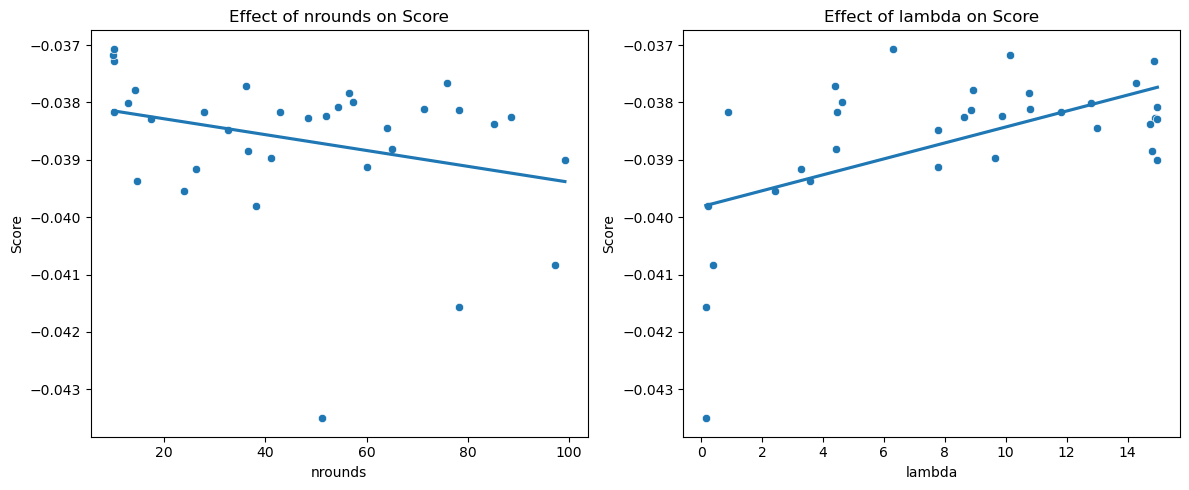

In [15]:
bayes_history = pd.DataFrame(optimizer.res)
bayes_history["eta"] = bayes_history["params"].apply(lambda x: x["eta"])
bayes_history["lambda_val"] = bayes_history["params"].apply(lambda x: x["lambda_val"])
bayes_history["nrounds"] = bayes_history["params"].apply(lambda x: x["nrounds"])

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.scatterplot(data=bayes_history, x="nrounds", y="target", ax=axes[0])
sns.regplot(data=bayes_history, x="nrounds", y="target", ax=axes[0], scatter=False, ci=None)
axes[0].set_title("Effect of nrounds on Score")
axes[0].set_xlabel("nrounds")
axes[0].set_ylabel("Score")

sns.scatterplot(data=bayes_history, x="lambda_val", y="target", ax=axes[1])
sns.regplot(data=bayes_history, x="lambda_val", y="target", ax=axes[1], scatter=False, ci=None)
axes[1].set_title("Effect of lambda on Score")
axes[1].set_xlabel("lambda")
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()
